# Lecture 3 - Randomization and Blocking

## Today's Learning Objectives

1. Explain foundational concepts of statistical design and analysis of experiments in a Data Science context.
2. Relate A/B and A/B/n testings to common statistical models via ordinary least-squares (OLS).
3. Fit and interpret appropriate OLS models from a factorial experiment.
4. Relate the corresponding ANOVA table to the substantive question of interest.
5. Introduce the concept of blocking in experimental design.
6. Contrast a blocking versus a non-blocking experimental model.

## Loading `R` Packages

In [1]:
options(repr.matrix.max.rows = 8)
library(tidyverse)
library(broom)

── Attaching core tidyverse packages ────────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors


## Previously...

In {doc}`lecture1_multiple_comparisons`, we explored key concepts such as **multiple testing** and its implications on the **inflation of the type I error** (**false positives!**) in hypothesis testing. This concept allowed you to draw proper inferential conclusions in the `lab1` case coming from [*Improving Library User Experience with A/B Testing: Principles and Process*](https://quod.lib.umich.edu/w/weave/12535642.0001.101?view=text;rgn=main) (Young, 2014).

Moreover, in {doc}`lecture2_simpson_confounding`, we discussed **confounding** and its role in critical issues such as the **Simpson's paradox**. Then, we explored the importance of **randomization** to obtain **accurate model estimates** in an **experimental study**. Randomization takes care of the confounders present in our population of interest, even when we do not include them in our modelling setup!

Even though we already introduced the concept of **A/B testing**, it is essential to keep digging into more experimental jargon (statistically speaking!). At the end of the day, **A/B testing** is basically a statistical experiment but with a really "self-descriptive" name.

Let us start with the foundations of **Design and Analysis of Experiments** in a Data Science context.

## 1. Foundations of A/B and A/B/n Testings

**A/B testing** involves a **randomized** experiment between two stategies: **control** (baseline or status quo) and **experimental** (variation) treatments. 

```{admonition} Example
:class: hint
Will changing the design of the website lead to a change in customer engagement (measured by the click-through-rates, CTRs)?
```

**A/B testing** is an experiment that aims to determine whether there is a statistical difference between both treatments in terms of a given **outcome of interest** (i.e., $Y$). 

More specifically, **A/B testing** is the Data Science-term applied to comparisons between two or more categories of a **factor-type variable** $X$ (i.e., its levels are our treatments of interest).

```{important}
Depending on the nature of the outcome (**continuous** or **discrete**), the statistical tool to compare the experimental treatments will vary. Let us practice our data modelling skills with some [**iCliker**](https://student.iclicker.com/#/login) questions.
```

```{exercise}
:label: lecture3-q1

In a given online store, when compared to a current website layout, you want to assess whether a new website layout will increase the average user spending in CAD (compared to the current website layout). 

**What statistical tool is suitable for analyzing your A/B testing data?**

**A.** A two-sample $t$-test.

**B.** Ordinary Least-squares (OLS) regression.

**C.** Multinomial Logistic regression.

**D.** A $Z$-test for two proportions.
```

```{exercise}
:label: lecture3-q2

Suppose you own a website and want to increase the visits to a specific section of interest (whose access button appears on the homepage). Thus, you randomize your experimental visitors to either one of two homepage layouts: $1$ or $2$. After the experiment, you compute the corresponding CTRs ($i = 1, 2$):

$$\text{CTR}_i = \frac{\text{Total number of clicks on the access button in the } i\text{th layout}}{\text{Total number of visits to the homepage under the } i\text{th layout}}.$$

**What statistical tool is suitable for analyzing your A/B testing data?**

**A.** A two-sample $t$-test.

**B.** Ordinary Least-squares (OLS) regression.

**C.** Multinomial Logistic regression.

**D.** A $Z$-test for two proportions.
```

```{exercise}
:label: lecture3-q3

Suppose you own a streaming service and want to increase the number of members in your **premium plan**. Then, you will run an A/B testing with current customers under the **standard plan**. You will **randomize** these current customers to one of these promotional videos on the premium plan: **current** or **new**. Furthermore, you also have **average customer-level monthly data** regarding how much time these customers spend on the platform (and want to incorporate that into your analysis!).

Finally, you will collect data on **whether these experimental customers migrated to the premium plan or not**.

**What statistical tool is suitable for analyzing your A/B testing data?**

**A.** Binary Logistic regression.

**B.** Ordinal Logistic regression.

**C.** Multinomial Logistic regression.

**D.** A $Z$-test for two proportions.
```

```{exercise}
:label: lecture3-q4

Suppose you want to increase customer satisfaction by improving your online store layout. Then, you will run an A/B testing. You will **randomize** your customers to one of these layouts: **current** or **new**.

Once the customer is done with their purchase, you will record their satisfaction via a quick question:

> **How satisfied were you with the purchase experience? Select one:**
>
> **1.** *Unsatisfied.*
>
> **2.** *A little bit unsatisfied.*
>
> **3.** *Neutral.*
>
> **4.** *A little bit satisfied.*
>
> **5.** *Satisfied.*

**What statistical tool is suitable for analyzing your A/B testing data?**

**A.** Binary Logistic regression.

**B.** Ordinal Logistic regression.

**C.** Multinomial Logistic regression.

**D.** A $Z$-test for two proportions.
```

Recall the **beauty of randomization**: it will make the regressor $X$ inherently independent of any possible confounding variables. Therefore, we will have the license to infer **causality**, rather than some weaker word such as **association**.

### What if we want to test more than two experimental treatments in our A/B testing?

In that case, the experiment will be called **A/B/n testing**. Note the **n** is not related to the sample size $n$. They just decided to call the testing that way.

## 2. A/B/n Testing with a Continuous Response

In {doc}`lecture2_simpson_confounding`, we firstly mentioned **Analysis of Variance (ANOVA)** as one possible **A/B testing** approach. This is just one specific class of OLS model (**a continuous response versus a categorical regressor**). **ANOVA** can also be used in **A/B/n testing**. We will explore this model via an example.

### 2.1. The Website Dataset

In your **A/B/n testing**, the next $n = 72$ visitors to your website will get assigned to a random version that varies in six possible ways according to combinations of the following variables:

- `Font`: A **factor-type** variable with three levels (`small`, `medium`, and `large`).
- Button `Colour`: A **factor-type** variable with two levels (`Red` and `Blue`).

Your outcome of interest $Y$ is the **continuous** `Duration` of the visit recorded for each visitor in minutes. The experimental data is contained in `AB_data`.

In [2]:
ABn_data <- read_csv("../data/ABn_data.csv", show_col_types = FALSE)
ABn_data <- ABn_data %>%
   mutate(Colour = as.factor(Colour), Font = as.factor(Font))
ABn_data

Duration,Colour,Font
<dbl>,<fct>,<fct>
90,Red,Small
95,Red,Large
107,Red,Medium
92,Red,Small
⋮,⋮,⋮
126,Blue,Medium
116,Blue,Small
136,Blue,Large
133,Blue,Medium


### 2.2. Experimental Terminology

The field of Design and Analysis of Experiments has some **key jargon** we need to learn. In the context of this problem, we will introduce some experimental design terminology.

Note that each subgroup of visitors sees one version of the website (**all possible six pairwise combinations** of `Small`/`Medium`/`Large` fonts and `Blue`/`Red` button colours). Therefore, let us make a list of experimental characteristics:

- The variables `Font` and `Colour` are called **experimental factors**.
- We consider an experiment with six **treatments** (i.e., the six possible pairwise level combinations of `Font` and `Colour`). This characteristic makes our experiment an **A/B/n testing** (more than two treatments!).

- Each visitor is called an **experimental unit**.
- Since we have more than one **experimental unit** by **treatment**, the experiment involves **replicates** (**$72 / 6 = 12$ per treatment**).
- Because the same number of **experimental units** is assigned to each treatment, the experiment is **balanced**.
- The **experimental units** were **randomized** to either one of the six **experimental treatments**.

- All six possible combinations of factor levels were used, so the experimental design is called a **full factorial** design.
- We might specifically call this a $2 \times 3$ **full factorial** design, since there are two factors (`Colour` with two levels and `Font` with three levels).

### 2.3. Main Statistical Inquiry

Once we have defined our experimental terminology, our main statistical inquiry is: 

> **What experimental treatment maximizes the `Duration` of the visit?** Suppose the **control treatment** corresponds to the **small font and blue colour**.

### 2.4. Exploratory Data Analysis

As in any other statistical analysis, we need to start with an exploratory data analysis (EDA). Since we have two **experimental factors** and a **continuous outcome**, we will use side-by-side boxplots.

In [3]:
options(repr.plot.height = 8, repr.plot.width = 14)

ABn_boxplots <- ggplot(ABn_data) +
  geom_boxplot(aes(Font, Duration, fill = Colour)) +
  theme(
    plot.title = element_text(size = 24, face = "bold"),
    axis.text = element_text(size = 17),
    axis.title = element_text(size = 21),
    legend.position = "bottom",
    legend.title = element_text(size = 21, face = "bold", margin = margin(r = 1, unit = "cm")), 
    legend.text = element_text(size = 17, margin = margin(r = 1, unit = "cm")),
    legend.key.size = unit(2, 'cm')
  ) +
  ggtitle("Side-by-Side Boxplots of Six Experimental Treatments") +
  xlab("Font") +
  ylab("Visit Duration (min)") + 
  scale_fill_manual(values = c("blue", "red"))

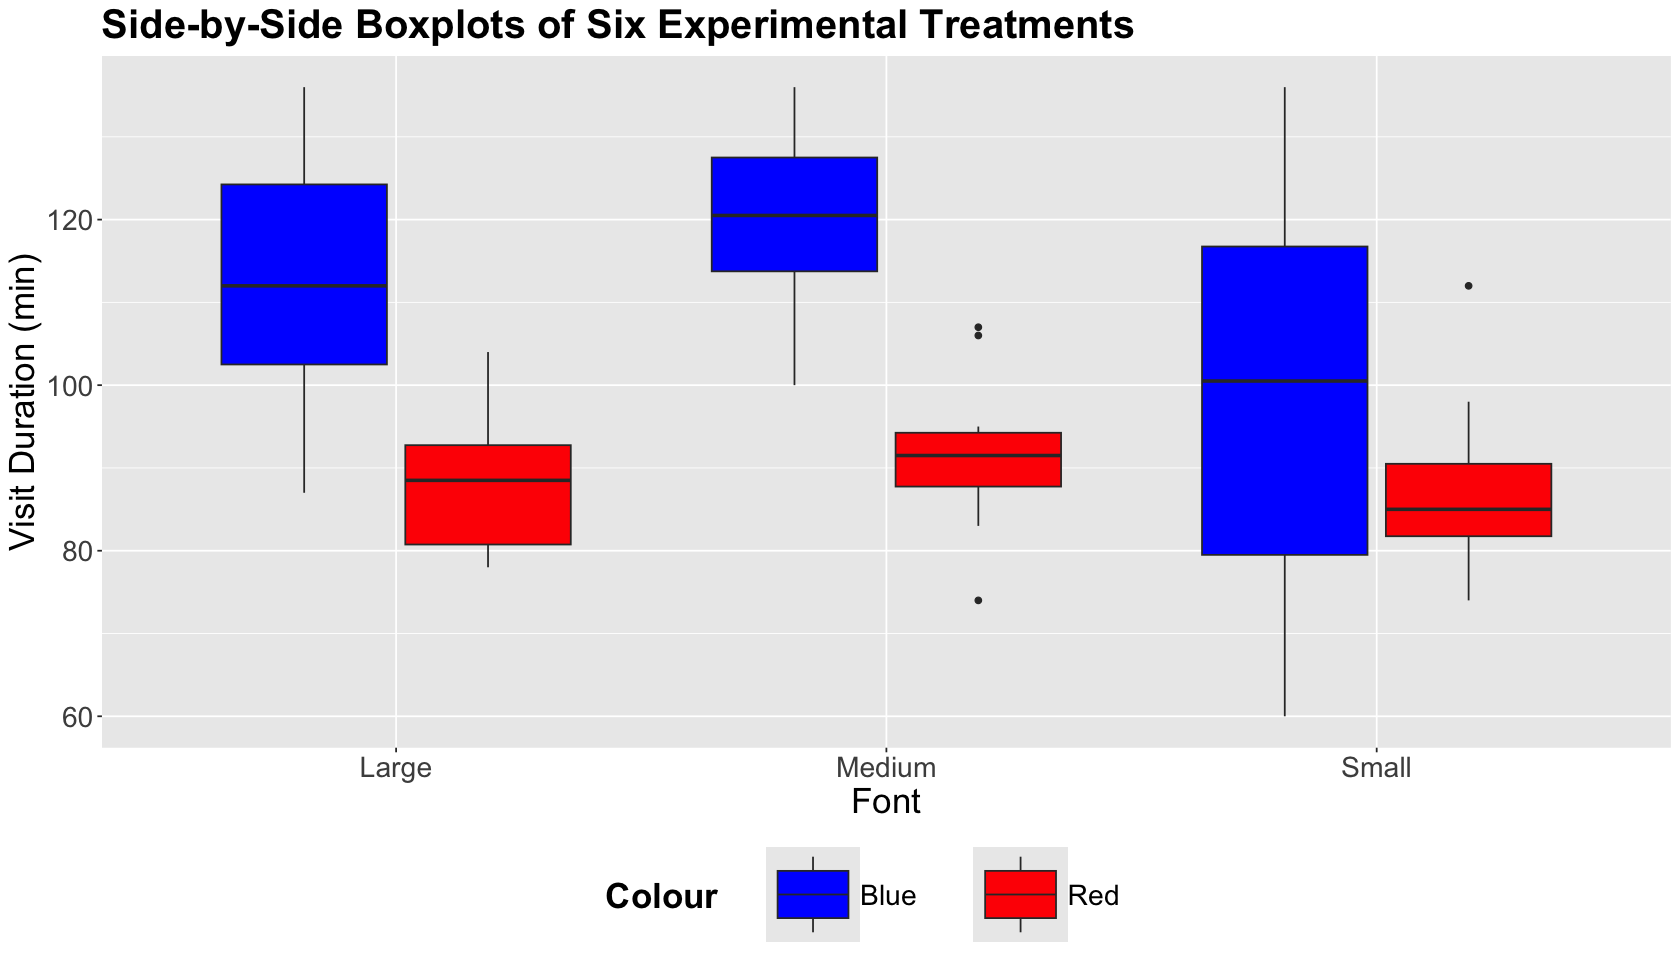

In [4]:
ABn_boxplots

We can **graphically** see that the treatments corresponding to the blue colour with medium font and the blue colour with large font maximize our outcome of interest.

### 2.5. Initial Data Modelling

We will proceed with some statistical modelling. The first model is called a **two-way ANOVA with main effects only**. 

```{important}
A **main effect** refers to a standalone regressor in our model.
```

In **experimental notation**, the response $Y_{i, j, k}$ for the $i$th `Font` level, the $j$th `Colour` level, and the $k$th **experimental unit** is decomposed as:

$$Y_{i,j,k} = \mu_{i} + \tau_{j} + \varepsilon_{i, j, k},$$

where:

- $\mu_i$ is the main effect on the mean response of the $i$th `Font` level (for $i = 1, 2, 3$),
- $\tau_{j}$ is the main effect on the mean response of the $j$th `Colour` level (for $j = 1, 2$), and 
- $\varepsilon_{i, j, k}$ is the error component assumed as independent, normally distributed, with mean zero and common variance $\sigma^2$ (for $k = 1, \dots, 12$).

We can fit this model with the `lm()` function.

In [5]:
# Releveling factors according to the control treatment
ABn_data$Colour <- fct_relevel(
  ABn_data$Colour,
  c("Blue", "Red")
)
ABn_data$Font <- fct_relevel(
  ABn_data$Font,
  c("Small", "Medium", "Large")
)

In [6]:
OLS_ABn_main_effects <- lm(formula = Duration ~ Font + Colour, data = ABn_data)
tidy(OLS_ABn_main_effects, conf.int = TRUE) %>% mutate_if(is.numeric, round, 2)

term,estimate,std.error,statistic,p.value,conf.low,conf.high
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
(Intercept),103.64,3.32,31.20,0.00,97.01,110.27
FontMedium,12.75,4.07,3.13,0.00,4.63,20.87
FontLarge,7.67,4.07,1.88,0.06,-0.45,15.78
ColourRed,-21.44,3.32,-6.46,0.00,-28.07,-14.82


The above `tidy()` output only sheds light on the fact that the **medium** `Font` and **red** `Colour` are statistically significant with $\alpha = 0.05$ to the baseline levels (**small** and **blue**). Nonetheless, we might better use an **ANOVA table**. 

```{important}
**ANOVA tables** go hand-in-hand with randomized experiments. **They are helpful to organize regression fits to factorial experiment data.** The table decomposes the **sum of squares** (i.e., variability) for each **experimental factor**. To obtain these tables, we can use the function `anova()`.
```

In [7]:
anova(OLS_ABn_main_effects) %>% mutate_if(is.numeric, round, 2)

,Df,Sum Sq,Mean Sq,F value,Pr(>F)
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Font,2,1977.44,988.72,4.98,0.01
Colour,1,8277.56,8277.56,41.69,0.00
Residuals,68,13501.44,198.55,NA,NA


The previous table will allow us to test the following **composite hypotheses** (i.e., we test more than one parameter at the same time) by **experimental factor**:

`Font`

```{math}
\begin{gather*}
H_0\text{: } \mu_1 = \mu_2 = \mu_3 \\
H_a\text{: at least one pair } \mu_u \neq \mu_v \text{ with } u \neq v.
\end{gather*}
```

`Colour`

```{math}
\begin{gather*}
H_0\text{: } \tau_1 = \tau_2 \\
H_a\text{: } \tau_1 \neq \tau_2.
\end{gather*}
```

With $\alpha = 0.05$, we can state that at least one pair of factor levels in `Font` is statistically different in terms of their mean responses. In the case of `Colour`, its two levels are statistically different in terms of their mean responses.

### 2.6. Data Modelling with Interaction

As a **general experimental guideline**, we should consider the potential for **interactions** with two or more factors. A **two-factor interaction plot** will give us a graphical insight into a statistically significant interaction.

```{important}
A **two-factor interaction plot** has the continuous outcome of interest on the $y$-axis and the **first factor** levels on the $x$-axis. The plot illustrates lines whose nodes correspond to mean responses by factor level. We can also plot error bars by a node. There will be as many coloured lines as levels in the **second factor**.
```

In [8]:
ABn_int_plots <- ABn_data %>% 
  ggplot(aes(x = Font, colour = Colour, group = Colour, y = Duration)) +
  stat_summary(fun = mean, geom = "point", size = 5) +
  stat_summary(fun = mean, geom = "line") +
  stat_summary(fun.data = mean_se, geom = "errorbar", width = 0.1) +
  theme(
    plot.title = element_text(size = 24, face = "bold"),
    axis.text = element_text(size = 17),
    axis.title = element_text(size = 21),
    legend.position = "bottom",
    legend.title = element_text(size = 21, face = "bold", margin = margin(r = 1, unit = "cm")), 
    legend.text = element_text(size = 17, margin = margin(r = 1, unit = "cm"))
  ) +
  ggtitle("Interaction Plots") +
  xlab("Font") +
  ylab("Visit Duration (min)") + 
  scale_color_manual(values = c("blue", "red"))

The interaction plot below corresponds to our case study. A graphical interaction will occur if one factor level (`Font`) differs by the level of the other factor (`Colour`) **while the lines cross**.

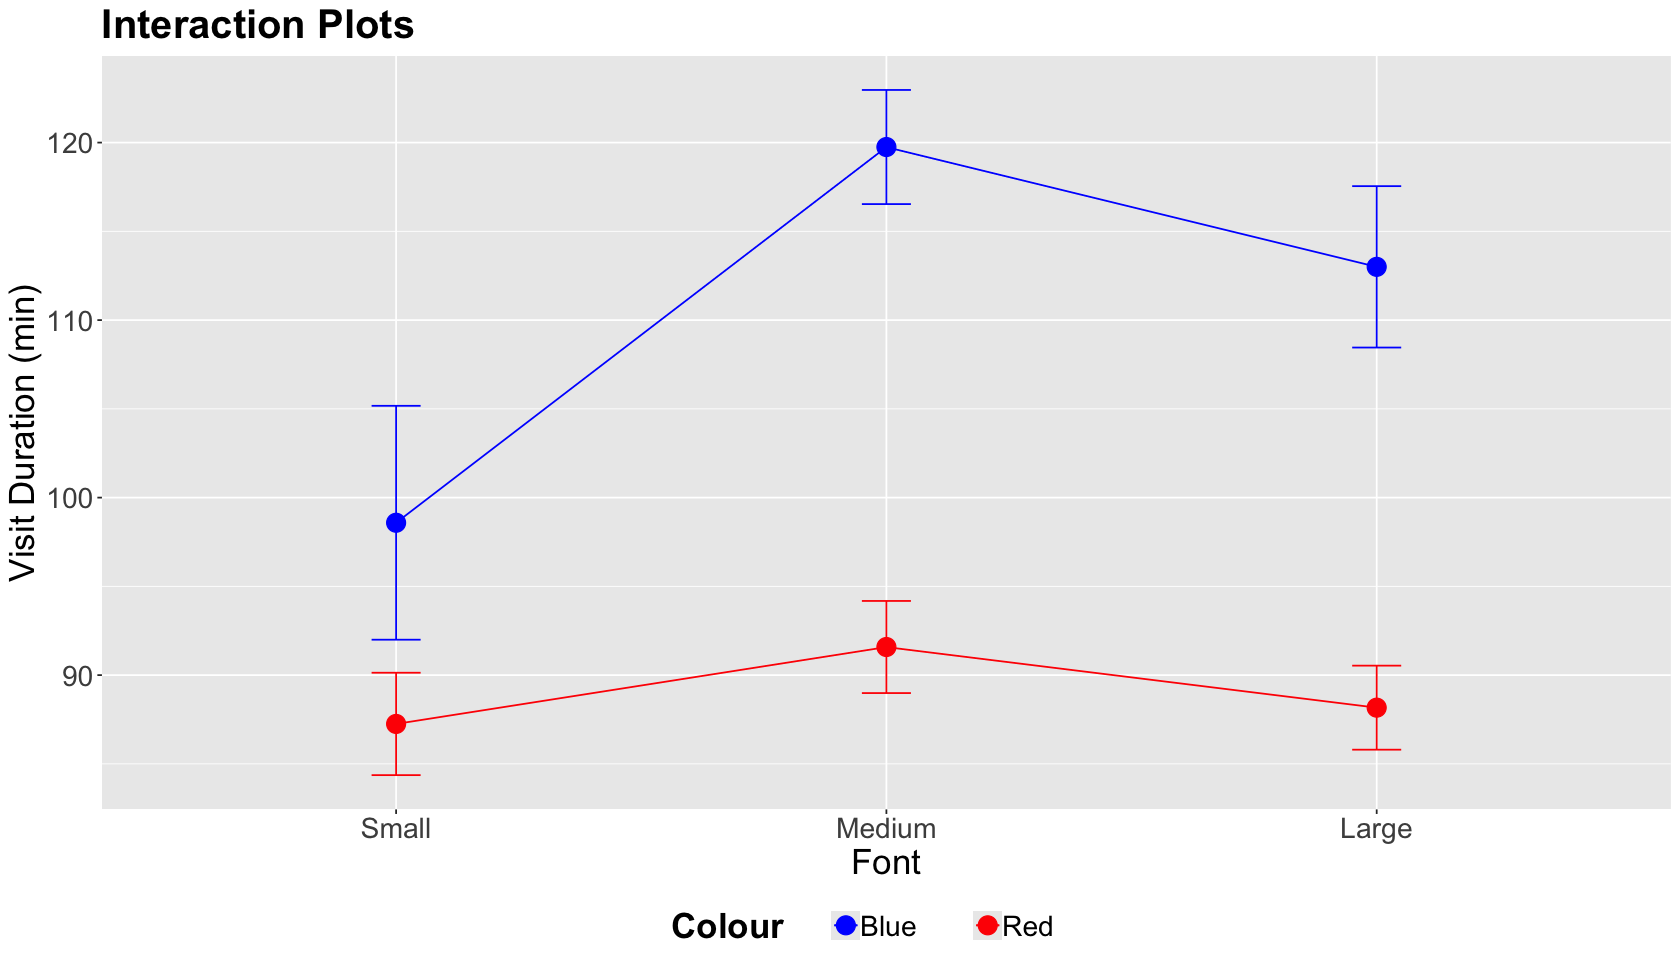

In [9]:
ABn_int_plots

In this case, the lines by `Colour` level do not cross while we vary `Font` sizes. Hence, **we do not have graphical evidence of a two-factor interaction**.

Now let us confirm the previous graphical result by fitting an OLS model that includes an interaction term, as shown below. This model is called a **two-way ANOVA with interaction effects**. This model includes both **main effects** and **two-factor interaction terms**. In **experimental notation**, the response $Y_{i, j, k}$ for the $i$th `Font` level, the $j$th `Colour` level, and the $k$th **experimental unit** is decomposed as:

$$Y_{i,j,k} = \mu_{i} + \tau_{j} + (\mu \tau)_{i, j} + \varepsilon_{i, j, k},$$

where:

- $\mu_i$ is the main effect on the mean response of the $i$th `Font` level (for $i = 1, 2, 3$), 
- $\tau_{j}$ is the main effect on the mean response of the $j$th `Colour` level (for $j = 1, 2$), 
- $(\mu \tau)_{i, j}$ is the interaction effect of both factors on the mean response of the $i$th and $j$th levels, and 
- $\varepsilon_{i, j, k}$ is the error component assumed as independent, normally distributed, with mean zero and common variance $\sigma^2$ (for $k = 1, \dots, 12$).

```{caution}
The term $(\mu \tau)_{i, j}$ **DOES NOT** indicate that the main effects are multiplying each other. Mathematically, it is **another** modelling term.
```

We use `Duration ~ Colour * Font` as a `formula` argument in `lm()`.

In [10]:
OLS_ABn_interaction <- lm(formula = Duration ~ Colour * Font, data = ABn_data)
tidy(OLS_ABn_interaction) %>% mutate_if(is.numeric, round, 2)

term,estimate,std.error,statistic,p.value
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
(Intercept),98.58,3.98,24.77,0.00
ColourRed,-11.33,5.63,-2.01,0.05
FontMedium,21.17,5.63,3.76,0.00
FontLarge,14.42,5.63,2.56,0.01
ColourRed:FontMedium,-16.83,7.96,-2.11,0.04
ColourRed:FontLarge,-13.50,7.96,-1.70,0.09


Again, the `tidy()` output might not be entirely informative. Hence, we use the function `anova()` to obtain the **ANOVA table** for this interaction model.

In [11]:
anova(OLS_ABn_interaction) %>% mutate_if(is.numeric, round, 2)

,Df,Sum Sq,Mean Sq,F value,Pr(>F)
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Colour,1,8277.56,8277.56,43.54,0.00
Font,2,1977.44,988.72,5.20,0.01
Colour:Font,2,953.44,476.72,2.51,0.09
Residuals,66,12548.00,190.12,NA,NA


The previous table will allow us to test the same **composite hypotheses** for the previous main effects plus the ones corresponding to the **two-factor interaction terms**:


```{math}
H_0\text{: } (\mu \tau)_{1, 1} = (\mu \tau)_{1, 2} = (\mu \tau)_{2, 1} = (\mu \tau)_{2, 2} = (\mu \tau)_{3, 1} = (\mu \tau)_{3, 2} \\
H_a\text{: at least one pair } (\mu \tau)_{u, v} \neq (\mu \tau)_{u', v'}.
```

The null hypothesis indicates that all interaction terms are on the status quo.

With $\alpha = 0.05$, we have evidence to reject the null hypotheses for the main effects **but not for the interaction effects**. Hence, any specific interaction (among the six possible ones) **DOES NOT** stand out as statistically significant.

```{admonition} Interlude: Counting parameters for main effects and two-factor interactions
:class: hint
The column `Df` in the **ANOVA table** represents the degrees of freedom for each class of modelling term. In a **two-way ANOVA with interaction effects**, if factor 1 has $p_{1}$ levels and factor 2 has $p_{2}$ levels then:

- $p_1 - 1$ degrees of freedom are needed for the main effect of factor 1.
- $p_2 - 1$ degrees of freedom are needed for the main effect of factor 2.
- $(p_1 - 1) \times (p_2 - 1)$ degrees of freedom are needed for the interaction between factor 1 and factor 2.
```

### 2.7. Post-Hoc Tests

Recall our main statistical inquiry:

> **What experimental treatment maximizes the `Duration` of the visit?** Suppose the **control treatment** corresponds to the **small font and blue colour**.

We will use the **two-way ANOVA with interaction effects** to answer this. However, we have only been able to answer whether the main or interaction effects are statistically significant or not **in general**. Therefore, we need to run **post-hoc tests**.

```{important}
The term "post hoc" means "after this" in Latin. A **post hoc test** in this class of experimental models refers to **all possible pairwise comparisons among the levels of the main and interactions effects after the model is estimated**. This matter involves **multiple testing corrections.**
```

As discussed in {doc}`lecture1_multiple_comparisons`, there is more than one multiple testing correction method. The same situation applies in ANOVA models. We will use the **Tukey's honestly significant differences (HSD)**. 

```{attention}
Tukey's HSD keeps the **family-wise error rate (FWER)** at $\alpha$ or below. **This method is only designed for ANOVA models.**
```

We will use the function `TukeyHSD()` to run this method. The function needs an `aov()` object as an input. **Function `aov()` is just an `lm()` wrapper specifically programmed for ANOVA models.** It also has `formula` and `data` arguments. The `tidy()` output is an **ANOVA table**.

```{important} 
`TukeyHSD()` function also has a `tidy()` output. We highlight the following:

- The output will show all the pairwise difference estimates (column `estimate`) among all main and interaction effect levels along with their corresponding confidence intervals (CIs) and adjusted $p$-values. 
- The column `null.value` corresponds to the hypothesized status quo difference, i.e., a difference equal to zero in $H_0$.
- An adjusted $p\text{-value} < \alpha$ indicates a statistically significant difference in a given level pair (column `contrast`) with significance level $\alpha$.
```

In [12]:
options(repr.matrix.max.rows = 20)

In [13]:
OLS_aov_ABn_interaction <- aov(formula = Duration ~ Colour * Font, data = ABn_data)
tidy(OLS_aov_ABn_interaction) %>% mutate_if(is.numeric, round, 2)

term,df,sumsq,meansq,statistic,p.value
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Colour,1,8277.56,8277.56,43.54,0.00
Font,2,1977.44,988.72,5.20,0.01
Colour:Font,2,953.44,476.72,2.51,0.09
Residuals,66,12548.00,190.12,NA,NA


In [14]:
tidy_tukey <- tidy(TukeyHSD(OLS_aov_ABn_interaction, conf.level = 0.95)) %>% mutate_if(is.numeric, round, 2)
tidy_tukey

term,contrast,null.value,estimate,conf.low,conf.high,adj.p.value
<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Colour,Red-Blue,0,-21.44,-27.93,-14.96,0.00
Font,Medium-Small,0,12.75,3.21,22.29,0.01
Font,Large-Small,0,7.67,-1.88,17.21,0.14
Font,Large-Medium,0,-5.08,-14.63,4.46,0.41
Colour:Font,Red:Small-Blue:Small,0,-11.33,-27.86,5.19,0.35
Colour:Font,Blue:Medium-Blue:Small,0,21.17,4.64,37.69,0.00
Colour:Font,Red:Medium-Blue:Small,0,-7.00,-23.52,9.52,0.81
Colour:Font,Blue:Large-Blue:Small,0,14.42,-2.11,30.94,0.12
Colour:Font,Red:Large-Blue:Small,0,-10.42,-26.94,6.11,0.44


Let us focus on the **significant** difference corresponding to the two-factor interaction, **specifically that containing the control treatment blue `Colour` and small `Font` (our CONTROL treatment)**. We can see that the **largest positive estimated difference** corresponds to `Blue:Medium-Blue:Small` with $21.17$ and a 95% CI of $[4.64, 37.69]$.

In [15]:
tidy_tukey %>%
  filter(adj.p.value < 0.05 & grepl("Blue:Small", contrast))

term,contrast,null.value,estimate,conf.low,conf.high,adj.p.value
<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Colour:Font,Blue:Medium-Blue:Small,0,21.17,4.64,37.69,0


**Hence, given the results of the A/B/n testing, the experimental treatment that maximizes the outcome of interest compared to the control treatment is the blue `Colour` with medium `Font`.** Note `Colour` did not make any difference but the `Font`. This fact is consistent with our interaction plot!

```{attention}
Other `aov()` post hoc tests are available through the `PostHocTest()` function via the package `DescTools`. Bonferroni correction is one of these alternative methods.
```

## 3. Blocking

The previous example involved two experimental factors (`Font` and `Colour`). Nonetheless, these two factors were our primary interest in the A/B testing. In some other cases, another class of factor could arise **and it will not be necessarily of our primary interest, nor we can control it**! These are the **blocking factors**.

```{important}
A **blocking factor** allows us to group our **experimental units** by common characteristics. Note that the experimenter does not have control over the blocking factor. **They just consider it as a grouping factor.**

These are some examples of blocking:

- Grouping the experimental units as **batches of material**.
- Grouping the experimental units by **time periods** during which the A/B testing occurs.
- Grouping our experimental units by **working shifts**.
```

One of the greatest statisticians who made important contributions to the field of Design and Analysis of Experiments was George E. P. Box (1919-2013). He is famous for his phrase: ["**Essentially all models are wrong, but some are useful.**"](https://rss.onlinelibrary.wiley.com/doi/pdf/10.1111/j.1740-9713.2010.00442.x) However, he also has another great phrase: "**Block what you can, randomize what you cannot.**"

```{hint}
Essentially, this phrase implicates the following:

- The **core idea** of blocking is removing the effect of secondary measurable variables from our response of interest. Hence, our statistical model could shed light on some statistical **association/causation** between the levels of a secondary blocking factor and our response of interest. 
- On the other hand, **experimental treatment** randomization takes care of other nuisance variables, which we cannot measure.
```

###  3.1. Blocking Procedure

So far, we have been discussing experiments where all of our experimental units are directly randomized to some treatment. Nevertheless, blocking involves a two-step process as follows.

1. Stratify your experimental units into homogeneous blocks. For instance, this stratification might be some relevant demographic variable in the case of human beings. Each stratum will be a block.
2. Randomize the units to the experimental treatments of interest within each block.

###  3.2. Simulation Setup

To get a handle on what blocking does, let us do a numerical experiment. 

```{admonition} Main statistical inquiry
Suppose you want to run an **A/B testing** on a **subscription website** to experiment with a new layout (i.e., the **experimental treatment**) to increase the mean duration time (hours) on your website (i.e., the **response**). You will compare this new layout versus the existing one (i.e., the **control treatment**). Thus, you will have an **experimental factor of interest** with two levels: **current** versus **new** layout.
```

```{admonition} Experimental Limitations
From the company's financial perspective, **A/B testing** is costly. Hence, they will only restrict the experiment to a sample of $n = 200$ subscribers.
```

In [16]:
set.seed(134) # Global reproducibility

n <- 200

```{admonition} Blocking Arrangement
Since this is a subscription website, assume we have access to **specific demographic categories** on our sampled subscribers. More particularly, there are ten demographic categories. We will take these categories as **blocks**. Therefore, our block-based A/B testing will be **balanced**, i.e., an equal number of sampled subscribers by block.
```

In [17]:
num_block <- 10
size_block <- n / num_block

###  3.3. Building our Synthetic Data

As done in {doc}`lecture2_simpson_confounding`, we will start by building our synthetic data (response and regressors). We already clarified our case will have ten demographic categories (or **blocks**). Each one of these categories will have **a different mean duration time on your website**. For the $i$th subscriber in the $j$th block, the response $Y_{i,j}$ will be decomposed and simulated as

$$Y_{i, j} = 8 + \alpha_{D_{j}} + \theta I_{\text{trt},i} + \varepsilon_{i, j},$$


where:

- $Y_{i,j}$ is the subscriber's duration time on the website.
- 8 hours is the average duration time on the website for all the **current subscribers**.
- $\alpha_{D_{j}}$ is the $j$th block effect **difference** (with respect to previous average duration time) which will take on ten values (depending on which block the subscriber belongs to, i.e., $j = 1, \dots, 10$). **The between-block variance will be $\sigma_D^2 = 2.5^ 2$.**
- $\theta$ is our **experimental treatment effect of interest**, i.e., by how much the response increases/decreases with the `new` layout compared to the `current` one.

- $\varepsilon_{i,j}$ is normally distributed **random noise** with mean zero and variance $\sigma^2 = 0.8^ 2$ (**this is the within-block variance**).
- $I_{\text{trt},i}$ is the indicator variable set up as

$$
I_{\text{trt},i} =
\begin{cases}
1 \; \; \; \; \mbox{if the subscriber was assigned to the } \texttt{new} \mbox{ layout},\\
0 \; \; \; \; 	\mbox{otherwise.}
\end{cases}
$$

We begin by simulating the ten values $\alpha_{D_{i, j}}$. They will be ten fixed values coming from a normal distribution with **mean zero** and between-block variance $\sigma_D^2 = 2.5^ 2$.

In [18]:
alpha <- rnorm(num_block, sd = 2.5)
round(alpha, 3)

[1] -2.101  2.956  0.698 -0.877 -3.195  1.541  4.831 -0.132  0.633  3.453

We also assign the **within-block standard deviation**:

In [19]:
sigma <- 0.8

And our experimental treatment effect of interest (the `new` layout increases the response by 0.5 hours compared to the `current` layout):

In [20]:
theta <- 0.5

Finally, we will create a **discrete probability distribution** to define how the subscriber population is distributed across the demographic strata.

In [21]:
dmg_dist <- seq(from = 5, to = 1, length = num_block)
dmg_dist <- dmg_dist / sum(dmg_dist)
round(dmg_dist, 2)
sum(dmg_dist)

[1] 0.17 0.15 0.14 0.12 0.11 0.09 0.08 0.06 0.05 0.03

[1] 1

Thus; 17% of the population belongs to demographic `1`, 15% to demographic `2`, 14% to demographic `3`, etc.

###  3.4. Experiment A: Without Blocking

Let us assume we obtain our sample of $n = 200$ subscribers, and we randomly assign them to either one of the experimental treatments of interest (`treat_exp_A`) **without taking into account the demographic blocks they belong to**.  

In [22]:
options(repr.matrix.max.rows = 8)

# We directly sample n = 200 subscribers from the population
# Balanced randomization by experimental treatment of interest (no blocking!)
treat_exp_A <- sample(c(rep(0, n / 2), rep(1, n / 2)))

# We need to simulate the demographic category (1 to 10) to construct our response y using 
# the discrete probability distribution dmg_dist!
dmg_exp_A <- sample(1:num_block, size = n, prob = dmg_dist, replace = T)

# Building our responses for experiment A according to our previous equation
y_exp_A <- rnorm(n, mean = 8 + alpha[dmg_exp_A] + theta * treat_exp_A, sd = sigma)

Our simulated data for **experiment A** is the following:

In [23]:
data_exp_A <- tibble(x = treat_exp_A, dmg = as.factor(dmg_exp_A), y = y_exp_A) %>%
   mutate(x = as.factor(ifelse(x == 1, "New Layout", "Current Layout")))
data_exp_A

x,dmg,y
<fct>,<fct>,<dbl>
New Layout,7,13.605402
New Layout,7,11.835148
New Layout,6,10.475998
New Layout,5,4.683586
⋮,⋮,⋮
Current Layout,1,4.919427
Current Layout,3,9.636866
Current Layout,2,12.277997
New Layout,1,7.338009


###  3.5. Experiment B: With Blocking

Now, let us randomize our treatments of interest within each one of the ten blocks. **There is no need to simulate the demographic category in this case since we exactly need 20 sampled subscribers per block.**

In [24]:
treat_exp_B <- NULL
dmg_exp_B <- NULL

for (i in 1:num_block) {

  # Each block has own balanced randomization
  treat_exp_B <- c(treat_exp_B, sample(c(
    rep(0, size_block / 2),
    rep(1, size_block / 2)
  )))

  dmg_exp_B <- c(dmg_exp_B, rep(i, size_block))
}

# Building our responses for experiment B according to our previous equation
y_exp_B <- rnorm(n, mean = 8 + alpha[dmg_exp_B] + theta * treat_exp_B, sd = sigma)

Our simulated data for **experiment B** is the following:

In [25]:
data_exp_B <- tibble(x = as.factor(treat_exp_B), dmg = as.factor(dmg_exp_B), y = y_exp_B) %>%
   mutate(x = as.factor(ifelse(x == 1, "New Layout", "Current Layout")))
data_exp_B

x,dmg,y
<fct>,<fct>,<dbl>
Current Layout,1,6.151177
New Layout,1,5.371058
Current Layout,1,5.009473
New Layout,1,6.584605
⋮,⋮,⋮
Current Layout,10,10.56169
New Layout,10,12.59774
New Layout,10,11.96537
Current Layout,10,11.08343


###  3.6. Data Analysis

```{attention}
Labels **A** and **B** for our experimental designs **ARE NOT** related to the name A/B testing.
```

We will use our simulated datasets `data_exp_A` and `data_exp_B` to fit the corresponding regression models. We will follow three modelling strategies.

#### Experiment A: Raw Model

This model will only regress the `y` on `x` (**current** versus **new** layout). This model is **STATISTICALLY TERRIBLE** since the regression coefficient of interest is not even significant! The only significant estimate is the one for the baseline `(Intercept)`, which is $8.10$. **This is happening because we are not capturing the right systematic component.**

In [26]:
exp_A_raw_model <- lm(y ~ x, data = data_exp_A) 
tidy(exp_A_raw_model, conf.int = TRUE) %>% mutate_if(is.numeric, round, 2)

term,estimate,std.error,statistic,p.value,conf.low,conf.high
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
(Intercept),8.10,0.26,31.32,0.00,7.59,8.61
xNew Layout,0.56,0.37,1.54,0.12,-0.16,1.29


#### Experiment A: Model with Post-Hoc Adjustment for Demographics

This model still uses the sample from **experiment A**, but we also include the sample demographic category `dmg` as a regressor. We have an accurate and precise estimate of $\theta$ of $0.42$ whose 95% confidence interval (CI) is $[0.20, 0.64]$. Note the `(Intercept)` estimate will include the baseline time plus the effect of the demographic category `1.`

In [27]:
options(repr.matrix.max.rows = 15)

exp_A_adj <- lm(y ~ x + dmg, data = data_exp_A)
tidy(exp_A_adj, conf.int = TRUE) %>% mutate_if(is.numeric, round, 2)

term,estimate,std.error,statistic,p.value,conf.low,conf.high
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
(Intercept),5.89,0.13,43.86,0,5.63,6.16
xNew Layout,0.42,0.11,3.72,0,0.20,0.64
dmg2,5.13,0.19,26.69,0,4.75,5.51
dmg3,2.85,0.19,14.67,0,2.46,3.23
dmg4,1.21,0.19,6.22,0,0.82,1.59
dmg5,-1.03,0.19,-5.30,0,-1.41,-0.65
dmg6,3.71,0.24,15.27,0,3.23,4.19
dmg7,6.93,0.21,32.68,0,6.51,7.35
dmg8,1.74,0.26,6.72,0,1.23,2.25


#### Experiment B: Model with Blocking

This model uses our data coming from the blocking design. It includes `x` and `dmg` as regressors. Again, we have an accurate and precise estimate of $\theta$ of $0.63$ whose 95% CI is $[0.42, 0.84]$. Note the `(Intercept)` estimate will include the baseline time plus the effect of the demographic category `1.` 

In [28]:
exp_B <- lm(y ~ x + dmg, data = data_exp_B) 
tidy(exp_B, conf.int = TRUE) %>% mutate_if(is.numeric, round, 2)

term,estimate,std.error,statistic,p.value,conf.low,conf.high
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
(Intercept),5.71,0.18,32.24,0,5.36,6.06
xNew Layout,0.63,0.11,5.90,0,0.42,0.84
dmg2,5.35,0.24,22.40,0,4.88,5.82
dmg3,2.80,0.24,11.72,0,2.33,3.27
dmg4,1.48,0.24,6.21,0,1.01,1.95
dmg5,-1.09,0.24,-4.56,0,-1.56,-0.62
dmg6,3.66,0.24,15.32,0,3.19,4.13
dmg7,7.45,0.24,31.18,0,6.98,7.92
dmg8,2.72,0.24,11.40,0,2.25,3.19


#### So, where are we standing?

It seems like **analyzing** the data in a way that acknowledges the demographic stratification is important for two strategies: **Model with Post-Hoc Adjustment for Demographics** and **Model with Blocking**. Therefore, **does a model with a blocking design have any advantage?**

Let us take a step further from our simulation in {doc}`lecture2_simpson_confounding` and obtain many samples **so we can deliver OVERALL PERFORMANCE METRICS** for our Monte Carlo simulation.

### 3.7. Running More Replicates

We can think of a single simulated dataset as a **demo** per strategy. Nonetheless, if we repeat our previous data simulations a considerable number of times (e.g., 500 replicates), we can look at the **average behaviour** of each modelling strategy. This is what we call a **statistical simulation study**.

The **average behaviour** will be tracked with the following metrics **per modelling strategy** with $\theta = 0.5$:

- **BIAS:** The average, over the 500 replicates, of $\hat{\theta} - \theta$. The larger the average, the less accuracy.
- **ROOT-MEAN-SQUARED ERROR (RMSE):** The square root of the average (over the 500 replicates) of $(\hat{\theta}-\theta)^{2}$.  It has the following characteristics:
    - Interpretable as the typical magnitude of estimation error.
    - Captures bias and variance involved in the procedure.
- **COVERAGE:** The proportion (among the 500 replicates) of the 95% CIs that contain the true $\theta$ value.
- **POWER:** It is applicable when $\theta \neq 0$. The proportion of the 500 95% CIs that exclude zero.

The code below executes the previous three strategies 500 times (`num_replicates`).

In [29]:
set.seed(554) # Global reproducibility
res <- list(NULL)
num_replicates <- 500
res[[1]] <- res[[2]] <- res[[3]] <- matrix(NA, num_replicates, 3)

for (lp in 1:num_replicates) {

  # No blocking
  treat_exp_A <- sample(c(rep(0, n / 2), rep(1, n / 2)))
  dmg_exp_A <- sample(1:num_block, size = n, prob = dmg_dist, replace = T)
  y_exp_A <- rnorm(n, mean = 8 + alpha[dmg_exp_A] + theta * treat_exp_A, sd = sigma)
  data_exp_A <- tibble(x = treat_exp_A, dmg = as.factor(dmg_exp_A), y = y_exp_A)

  # Blocking
  treat_exp_B <- NULL
  dmg_exp_B <- NULL
  for (i in 1:num_block) {
      
     treat_exp_B <- c(treat_exp_B, sample(c(
       rep(0, size_block / 2),
       rep(1, size_block / 2)
     )))

     dmg_exp_B <- c(dmg_exp_B, rep(i, size_block))
   }
  y_exp_B <- rnorm(n, mean = 8 + alpha[dmg_exp_B] + theta * treat_exp_B, sd = sigma)
  data_exp_B <- tibble(x = treat_exp_B, dmg = as.factor(dmg_exp_B), y = y_exp_B) 

  
  # Do the three analyses
  exp_A_raw_model <- lm(y ~ x, data = data_exp_A) 
  exp_A_adj <- lm(y ~ x + dmg, data = data_exp_A) 
  exp_B <- lm(y ~ x + dmg, data = data_exp_B)

  # And the takeaways
  res[[1]][lp, ] <- c(coef(exp_A_raw_model)["x"], confint(exp_A_raw_model)["x", ])
  res[[2]][lp, ] <- c(coef(exp_A_adj)["x"], confint(exp_A_adj)["x", ])
  res[[3]][lp, ] <- c(coef(exp_B)["x"], confint(exp_B)["x", ])
}

Then, we compute each one of the above metrics.

In [30]:
### Summaries
BIAS <- sapply(
  res,
  function(mat) {
    mean(mat[, 1]) - theta
  }
)
vrnc <- sapply(res, function(mat) {
  var(mat[, 1])
})
CVRG <- sapply(res,
  function(mat, trg) {
    mean((mat[, 2] < trg) & (trg < mat[, 3]))
  },
  trg = theta
)
PWR <- sapply(res, function(mat) {
  mean(mat[, 2] > 0)
})
RMSE <- sqrt(BIAS^2 + vrnc)

opt <- cbind(BIAS, RMSE, CVRG, PWR)
rownames(opt) <- c("Raw Model A (nothing)", "Adjusted Model A (dmg as a covariate)", "Model B (blocking)")

#### What is the conclusion by looking at these metrics by strategy?

Blocking can be your friend, both in study design as in **Model B (blocking)** and data analysis as in **Adjusted Model A (`dmg` as a covariate)**. We can see that **Model B (blocking)** has a slightly smaller **BIAS** and **RMSE**. 

In [31]:
round(opt, 4)

,BIAS,RMSE,CVRG,PWR
Raw Model A (nothing),0.0092,0.3652,0.934,0.286
Adjusted Model A (dmg as a covariate),0.0047,0.1145,0.946,0.986
Model B (blocking),-0.0011,0.1135,0.950,0.992


##  4. Wrapping Up

We have covered foundational experimental jargon and techniques, which will be helpful for A/B and A/B/n testings. Moreover, recall that these tests need to be adapted to our outcome of interest. Post hoc tests are handy to address our statistical inquiries (you actually did this in `lab1`!).

An important matter to consider regarding blocking is that this strategy will work as long as the blocks are really homogeneous. This implicates stratifying the experimental units into blocks so that:

- As much variation in $Y$ as possible is **across** the blocks.
- As little variation in $Y$ as possible is **within** the blocks.